# Forecasting service scale-out using Azure Storage and VSCode Jupyter Notebooks #

As you may or may not know, VSCode has been busy enabling Jupyter Notebook functionality within the editor, which to those of us with our fingers in data analytics, is quite a nice boon to simplify our dev workflows and environments.

Towards that effort, we hope to take this opportunity to walk through some interesting end-to-end examples of leveraging this tooling alongside our Azure capabilities (Blob storage, in this case).

For this writeup, we'll demonstrate how to leverage App-Insights data (or really, any ad-hoc system-scale-related-telemetry) flowing into Azure Blob, to be consumed via experimentation in VSCode Jupyter for the purpose of designing a predictive model to anticipate service scale up/down, a common task for optimizing cloud spend and anticipating scale requirements.

<p align="center">
    <img src="https://camo.githubusercontent.com/1acea3f1c347974d095b303ee4e4d8b33cc4901e/687474703a2f2f616c6b616c696e652d6d6c2e636f6d2f696d672f7374617469632f706d646172696d615f726561646d655f6578616d706c65312e706e67">
</p>

## Getting Started ##
For this exercise we'll need a few things.

1. VSCode
  - VSCode installed via [this link](https://code.visualstudio.com/).
  - VSCode Python Extension installed, as demonstrated in [this tutorial](https://code.visualstudio.com/docs/python/python-tutorial).  You can alternately select to install this when prompted upon opening your first "ipynb" (jupyter notebook) file.
  - Python "jupyter" and "notebook" modules installed.  If the above steps have been completed, you will be prompted to install this upon attempting to run the notebook you've opened.
2. Azure Account
  - An Azure Account is needed to interact with the Azure Storage components of this demo, and can be created on [the Azure portal](https://portal.azure.com).

## Environment Setup ##

In the interests of being self-referential, the first thing to do is download [this demo as an .ipynb](https://kibrantnstoragetest.blob.core.windows.net/public/ForecastingInVSCodeWithBlob.ipynb) and open it in VSCode.  You'll be able to follow along and run the code as you go, and see firsthand how notebooks can be used to intermesh code and documentation seamlessly with your dev environment.  Use the controls at the top of the editor, or on the cell itself, to progress through cells and run the code.

<p align="center">
    <img src="https://code.visualstudio.com/assets/docs/python/jupyter/native-code-cells-03.png">
</p>

Next, we'll consume some python libraries to interact with Azure and perform our analytics.  Running the following cell will install those libraries, while demonstrating how to install packages within a notebook via "!" notation.  
**Note:** The odd quotation and sys executable syntax you see is to ensure it works regardless of if your system python is set distinctly from your kernel, or if the path to the kernel includes a space.

In [ ]:
import sys #To ensure we're using the right version of python, since ! tries to use system, and % doesn't natively handle windows paths with spaces well.

# Azure storage SDK and identity package to authenticate.
!"{sys.executable}" -m pip install azure-storage-blob azure-identity
# Our data manipulation bread and butter.
!"{sys.executable}" -m pip install pandas numpy sklearn
# Basic visualization
!"{sys.executable}" -m pip install matplotlib
# Tooling to perform ARIMA forecasts. This may take a moment.
!"{sys.executable}" -m pip install pmdarima
# Just in case, ensure we have the python modules we need to run the rest of this notebook.
!"{sys.executable}" -m pip jupyter notebook

#If you hit permission issues when running this command, your kernel may be set to system python.  Install manually or change your kernel.

Finally, you'll need to provide permissions via Azure to perform the cloud operations detailed below, as well as the names of data input and output locations to be used throughout this piece.  This can be skipped if desired, as we do provide sample data for the numerical portion of this, but nonetheless hope the remainder can provide an example of how one typically interacts with these Azure resources.  We also hope this demonstrates an interesting flow of data to easily gain insights on your system behavior. 

While authentication can be commonly done via connection string, we'll use the InteractiveBrowserCredential flow here that doesn't require fetching as much information from the Azure portal.  This is just one way to authenticate.  One could also use DefaultAzureCredential via service principle credentials placed in Environment variables, for instance. [See this example for more details.](https://github.com/Azure/azure-sdk-for-python/blob/fd77736ec87af50a108f461f1e78ad11314942ee/sdk/storage/azure-storage-blob/samples/blob_samples_authentication.py#L124)

In [1]:
from azure.identity import InteractiveBrowserCredential

credential = InteractiveBrowserCredential()

# The subscription ID you'll be utilizing
subscription_id = ''
# The storage account to extract app insights logs from, and/or to write model metadata to.
input_storage_account_name = ''
# The resource group to create a storage account from, if a distinct location is desired for model metadata being output.
output_resource_group = ''
# If present, the distinct storage account to create for output data; otherwise the input_storage_account will be used.
output_storage_account_name = ''
# The container to create and store output data in.
output_container_name = ''
# The credentials needed for a service principle with authentication to the subscription for creating the output resources.
tenant_id = ''
client_id = ''
client_secret = ''

from azure.identity import ClientSecretCredential
credential = ClientSecretCredential(tenant_id, client_id, client_secret)

# These settings are only relevant if you are following along with your own app-insights blob-exported data.os
# The name of the container app-insights is sending data into.
app_insights_container_name=''
# The path your app-insights export is storing blobs under.
app_blob_path = ''

## Obtaining the Data ##

We can now access the storage account in Azure where our data is located.  This example assumes an App service setup wherein AppInsights uses [continuous export](https://docs.microsoft.com/en-us/azure/azure-monitor/app/export-telemetry) to populate log data into Azure Blob Storage, but the numerical approach that follows could reasonably be applied to any similarly shaped data.

Below, we use the Azure Blob Storage SDK to connect to the storage account, enumerate blobs, and download their contents.  A Blob is effectively an unstructured block of bytes (often textual, but doesn't have to be) stored at a given path within a container of a Storage Account.  In this case it will contain the JSON-formatted logs output by our app service via App Insights.

If you aren't modeling against app insights data, feel free to skip to the [Preparing Data](#PreparingtheData) subsection and resume execution there.  The key to this exercise is simply having data that gives you insight into the usage rates of your system over time; we use a count of total requests below.

First things first, we have to connect to our storage account using the credentials we created above.

In [2]:
from azure.storage.blob import BlobServiceClient

def create_service_client(storage_account_name, credential):
    oauth_url = "https://{}.blob.core.windows.net".format(
        storage_account_name
    )
    return BlobServiceClient(account_url = oauth_url, credential=credential)

service_client = create_service_client(input_storage_account_name, credential)

We can now use this client to enumerate and fetch the logs stored in blobs within a container on the specified storage account.  This example assumes use of the App Insights continual data export functionality, a convenient way to egress raw app-service request data into a persisted environment, although it requires a small amount of work below to extract the relevent bits (times and counts of requests) from the raw logs and structure them conveniently.

If you receive an authentication error in this section, check that the user or service principle backing the credential being used has "Blob Data Owner" permissions to the storage account in question; Owner itself is not sufficient.

In [3]:
import json
import pandas
from datetime import datetime, timedelta

def extract_requests_from_app_insights_container(service_client, app_blob_path, container_name, start_time=None, end_time=None):
    '''AppInsights stores data in a series of folders (Metrics, Requests, etc) within a container.  This function 
    enumerates the blobs within the Requests folder, extracting the JSON-formatted request logs from within it and 
    storing their counts and timestamps to a dataframe for easy consumption.'''

    data = pandas.DataFrame(columns=['count'])    
    container = service_client.get_container_client(container_name)
    # For even more efficient filtering, we could include components of the date in the matching prefix, such as Requests/2020-04-
    blob_list = container.list_blobs(app_blob_path + '/Requests/')
    for blob in blob_list:
        body = container.download_blob(blob.name).readall().decode('utf8')
        for request_string in body.split('\n'):
            try:
                request = json.loads(request_string)
                # Convert from string to date.  Massage the format slightly to match.
                event_time = datetime.strptime(request['context']['data']['eventTime'][:-2], r'%Y-%m-%dT%H:%M:%S.%f')
                if event_time < start_time or event_time > end_time:
                    continue
                count = sum(r['count'] for r in request['request'])
                data.loc[event_time] = count
            except:
                continue
    return data

data = extract_requests_from_app_insights_container(service_client, app_blob_path, app_insights_container_name, datetime.utcnow() - timedelta(hours=3), datetime.utcnow())

## Preparing the Data ##

If Azure is not being used, please feel free to download our sample data from the following link as demonstrated.  As an added bonus, let it be noted that a public Azure blob (be careful when using this!) is accessable to the world via HTTP, we have utilized this to host the sample data, which can be readily downloaded and extracted for users following along without their own App Insights setup.

In [ ]:
import pandas
data = pandas.read_csv(r"https://kibrantnstoragetest.blob.core.windows.net/public/synthetic_data.csv", parse_dates=[0], index_col=[0])

Now that we have the raw data, let's aggregate it into a useful granularity to do forecasting.  The initial data is per-event, whereas it would be far more useful for our needs to have it bucketed by a timespan that allows us to see the underlying pattern we're hoping to model.  For our synthetic data, we'll do 2 minute buckets; this may naturally differ with other datasets but the goals are the same, to produce a continuous and non-sparse representation of the desired load trend, smoothing over short-term variance without losing too much signal.

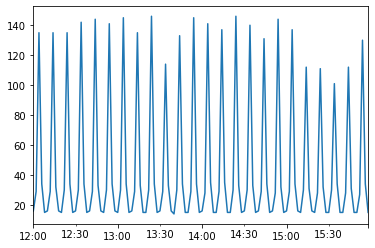

In [4]:
grouped_data = data.groupby(pandas.Grouper(freq='2Min')).agg({'count'})
grouped_data.plot(legend=False)

Looking good!  We can also see here how easy it is within a Jupyter Notebook to embed visualizations.  Whereas in the past you might have needed to output a plot to a file, now you can simply generate it inline and trivially regenerate to observe as your data changes.

## Modeling the Data ##

Now that we have a reasonably clean dataset to work off of, we can try to apply forecasting techniques to give ourselves a window into future behavior.  We're going to utilize an ARIMA model for this task.  Without going too far into the weeds, this is an algorithm that uses historical data in an attempt to determine and utilize the underlying periodicity/seasonality coupled with underlying moving averages for prediction.  For those familiar with simpler regression-based approaches (e.g. linear, polynomial), ARIMA can often better capture higher order behavior by leveraging seasonal look-backs, making it a very convenient and useful tool for the sort of data patterns we often see in service infrastructure.

Since there is often a lot of legwork in determining the proper parameters to an ARIMA model outside the scope of this post, we're going to take the easy way out and utilize an auto-arima package that will attempt to determine the optimal structure of this model for us.  This can often be sufficient for well-structured and regular data.

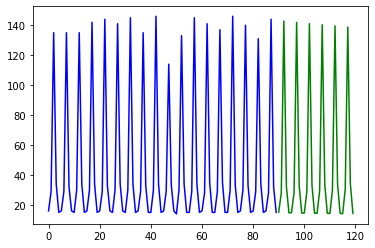

In [5]:
from pmdarima import auto_arima
from pmdarima.model_selection import train_test_split
from matplotlib import pyplot
import numpy

# Training a model is _VERY EASY_, although it should be noted that one can tune these functions if a different train/test split, or arima parameters, is desired.
train, test = train_test_split(grouped_data)
model = auto_arima(train, suppress_warnings=True)

# Let's visualize our results to get a sense for how well our prediction is working.
forecast = model.predict(test.shape[0])
x = numpy.arange(grouped_data.shape[0])
pyplot.plot(x[:len(train)], train, c='blue')
pyplot.plot(x[len(train):], forecast, c='green')
# pyplot.plot(x[len(train):], test, c='orange') # If it's desired to compare vs. actual results, uncomment this.
pyplot.show()

We see that the forecast captures the primary data trend rather nicely.  We can add the left-out test data to the chart above by uncommenting the remaining pyplot stanza and rerunning to get an idea of how well it has been fit, and observe that the delta is acceptably small.

** As a pragmatic note: **  It can often be wise to not include all historical data when training your model; this may result in overfitting if the behavior of the data changes subtlely.  Finding a balance between "enough data to capture the trend" and "not enough to overfit" is an important question to ask, and should be re-evaluated over time as the underlying data changes.  A notebook (such as this one!) can help for easily evaluating that manually, and can give inspiration for how this process could be automated, potentially using blob storage as well for persistance of model metadata.

## Using Azure Storage to iterate and automate ##

Once we have a promising model, the next step is to ensure it does not regress, and to tune parameters.  A common pattern for this is to store the hyperparameters and model outcomes in a persisted data store to track performance over time.

If the user provided it earlier, we'll reuse the existing storage account we extracted telemetry data from, but for the purposes of demonstrating resource creation, and to decouple the earlier logic for readers following along without an AppInsights setup, we'll also assume nothing exists at this point other than the authenticated azure credentials from earlier.

Let's begin by capturing some metrics to denote our models current state.

In [6]:
from sklearn.metrics import mean_squared_error

# Root mean squared error, a common method for observing the delta between a forecast and the source-of-truth.
rmse = numpy.sqrt(mean_squared_error(test, forecast))
# Akaike's information criterion, a measure that also folds the "simplicity" of the model into the score.
aic = model.aic()
# We should also record what data we were "up to" when we made this forecast.
forecast_time = test.index[-1]
# And finally let's get the parameters of the model
params = model.params()

We now need to put these values somewhere to persist them for the future.  We'll leverage the Azure Storage Management SDK this time, creating a blob to store this data, demonstrating how to use the azure-mgmt-storage SDK in the process.  It should be mentioned that any sort of structured datastore would be sufficient, (tables, sql, nosql, etc.) we chose blob primarily to avoid introducing more new concepts at this point in the post.

Let's create a new storage account to start, using the azure-mgmt-storage SDK and our existing credentials.  This section requires the subscription_id and the resource group the storage account should live within, as well as the credentials you provided prior.

In [7]:
# Management operations use a different set of credentials than data-plane operations.  This will be unified in the near-future.
from azure.common.credentials import ServicePrincipalCredentials
management_credential = ServicePrincipalCredentials(client_id, client_secret, tenant=tenant_id)

from azure.mgmt.storage import StorageManagementClient
from azure.mgmt.storage.models import StorageAccountCreateParameters, Sku, SkuName, Kind, Reason
management_client = StorageManagementClient(management_credential, subscription_id)
# In case a user is picking up from where we left off, let's leverage that storage account.
storage_account_name = input_storage_account_name or output_storage_account_name
availability = management_client.storage_accounts.check_name_availability(storage_account_name)
if availability.name_available: 
    management_client.storage_accounts.create(
        output_resource_group, 
        storage_account_name, 
        StorageAccountCreateParameters(
            sku=Sku(name=SkuName.standard_lrs),
            kind=Kind.storage,
            location='westus2'
        ))
else:
    print("Warning: Storage account already exists")

Our new storage account now exists (or we're leveraging one from earlier), so let's create a container within it to store our data, and then emplace it there.

In [8]:
# Technically we don't need to recreate this, but not assuming readers ran the prior step if they skipped Azure egress.
from azure.storage.blob import BlobServiceClient
from azure.core.exceptions import ResourceExistsError
oauth_url = "https://{}.blob.core.windows.net".format(
        storage_account_name
    )
service_client = BlobServiceClient(account_url = oauth_url, credential=credential)

# Now create the actual container
try:
    service_client.create_container(output_container_name)
except ResourceExistsError:
    print("Warning: Container already exists")

# And populate our data within a blob.
import json
blob_client = service_client.get_blob_client(output_container_name, str(forecast_time))
try:
    blob_client.upload_blob(json.dumps({'rmse':rmse, 'aic':aic, 'forecast_time':str(forecast_time), 'params':list(params)}))
except ResourceExistsError:
    print("Warning: Blob already exists")

We can then take steps similar to fetching the initial log data above, to pull down the model logs for inspection; for instance to watch for or understand a regression in model performance.

In [9]:
container = service_client.get_container_client(output_container_name)
    blob_list = container.list_blobs()
    for blob in blob_list:
        body = json.loads(container.download_blob(blob.name).readall().decode('utf8'))
        print(body)

{'rmse': 11.92085713990942, 'aic': 575.4807808475052, 'forecast_time': '2020-04-23 15:58:00', 'params': [50.01749991611674, -0.2116558444514789, -0.21623675018538668, -0.21730199448346543, -0.2105081029632333, 0.7779167602580747, 0.06072415074177533, 22.84579391089592]}


## Conclusion ##

We've demonstrated through this writeup how to consume semi-structured log data, transform it into a useful form, perform analytics, and publish those results for further use.  While this was a rather self-contained and tightly scoped example, this pattern (and technique) is quite close to the structure of commonly used systems for understanding and acting on timeseries data.

We hope to have also shown the utility of Jupyter Notebooks for interactive data exploration and communication, coupled with the capabilities of Azure Storage for data storage and persistance.

With these tools we hope to leave you well equipped for your own data journey.